#### Convolutional Neural Networks :  Cats vs Dogs  (with GPU support)

In [1]:
import torch
import torchvision
import numpy as np

In [2]:
import os
import cv2
from tqdm import tqdm


In [99]:
REBUILD_DATA = False
class dvc():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS :0 , DOGS :1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for file in tqdm(os.listdir(label)):
                try:   #SOME IMAGES MAYBE CORRUPT
                    path = os.path.join(label,file)
                    #convert image to grayscale to keep it simple
                    img = cv2.imread(path)#, cv2.IMREAD_GRAYSCALE)
                    #resize to 50*50
                    #print(img)
                    img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])
                    #print(label,self.CATS)
                    if str(label) == str(self.CATS):
                        self.catcount += 1
                    elif str(label) == str(self.DOGS):    
                        self.dogcount += 1
                except Exception as e:
                    print(e)
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        
        print("Cat class = ",self.catcount)
        print("Dog class = ",self.dogcount)
        
if REBUILD_DATA:
    dc = dvc()
    dc.make_training_data()
    
    
         
                
                
        

In [100]:
len(dc.training_data) 

24946

In [101]:
training_data[1]

array([array([[254, 254, 254, ..., 254, 254, 254],
       [254, 254, 254, ..., 254, 254, 254],
       [254, 254, 250, ..., 253, 253, 253],
       ...,
       [173, 159, 226, ..., 228, 221, 199],
       [191, 213, 237, ..., 204, 179, 206],
       [221, 213, 165, ..., 241, 240, 229]], dtype=uint8),
       array([1., 0.])], dtype=object)

In [102]:
training_data = np.load("training_data.npy",allow_pickle=True)

#### Meow

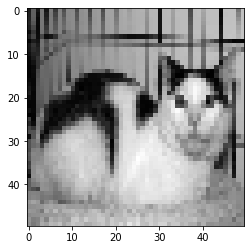

In [103]:
import matplotlib.pyplot as plt
plt.imshow(training_data[2][0],cmap="gray")
plt.show()

#### CNN Architecture 

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
class cnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)      # 1 image, 32 channels, 5*5 krnel default stride=1
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
    
        x = torch.randn(1,50,50).view(-1,1,50,50)
        self.to_linear = None   #auxillary variable to calculate shape of output of conv+max_pool
        self.convs(x)        
        
        self.fc1 = nn.Linear(self.to_linear,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,2)
        
    def convs(self,x):

        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        #x = self.model(x)
        if self.to_linear is None:
            self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self.to_linear)   #flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim=1)
        


In [105]:
torch.cuda.is_available()

True

In [106]:
torch.backends.cudnn.enabled

True

In [107]:
## Do check for cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU Process")
else:
    device = torch.device("cpu")
    print("CPU Process")

GPU Process


In [108]:
#device = torch.device("cpu")

In [109]:
net = cnet().to(device)   #transferiing class objet to gpu

In [94]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.BCELoss()

In [84]:
#PREPARING TRAINING,TESTING

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [85]:
training_data[2]

array([array([[ 21,  66,  18, ..., 128,  79, 129],
       [ 23,  66,  12, ..., 128,  88, 129],
       [ 25,  64,   8, ..., 128,  97, 129],
       ...,
       [ 93,  96,  97, ..., 104,  82,  88],
       [ 99,  85,  88, ...,  74,  96,  96],
       [ 96,  82,  90, ...,  93,  89,  94]], dtype=uint8),
       array([1., 0.])], dtype=object)

In [86]:
y[2]

tensor([1., 0.])

In [87]:
val_ratio = 0.1
val_size = int(len(X)*val_ratio)
print(val_size)

2494


In [88]:
train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]

In [89]:
print(len(train_X),len(train_y))

22452 22452


In [95]:
def train(net):    
    BATCH_SIZE = 64
    EPOCHS = 15
    for epoch in range(EPOCHS):
        for i in tqdm(range(0,len(train_X),BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]
            batch_X,batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()
            out = net(batch_X)
            #print(out.size())
            #print(batch_y.size())
            loss = loss_function(out,batch_y)
            loss.backward()
            optimizer.step()
        print("Epoch = "+str(epoch)+", loss = "+str(loss))

In [96]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            #print(net_out)
            #print(real_class)
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))

In [97]:
train(net)

  3%|▎         | 9/351 [00:00<00:04, 79.69it/s]

Epoch = 0, loss = tensor(0.6365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 8/351 [00:00<00:04, 79.69it/s]

Epoch = 1, loss = tensor(0.6015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 8/351 [00:00<00:04, 79.70it/s]

Epoch = 2, loss = tensor(0.5590, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 8/351 [00:00<00:04, 79.39it/s]

Epoch = 3, loss = tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 8/351 [00:00<00:04, 75.71it/s]

Epoch = 4, loss = tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 9/351 [00:00<00:04, 80.60it/s]

Epoch = 5, loss = tensor(0.5432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  2%|▏         | 8/351 [00:00<00:04, 79.79it/s]

Epoch = 6, loss = tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 9/351 [00:00<00:04, 80.28it/s]

Epoch = 7, loss = tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 9/351 [00:00<00:04, 80.13it/s]

Epoch = 8, loss = tensor(0.4724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 9/351 [00:00<00:04, 80.76it/s]

Epoch = 9, loss = tensor(0.4286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 9/351 [00:00<00:04, 80.75it/s]

Epoch = 10, loss = tensor(0.3898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 9/351 [00:00<00:04, 80.05it/s]

Epoch = 11, loss = tensor(0.3928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 9/351 [00:00<00:04, 80.52it/s]

Epoch = 12, loss = tensor(0.2978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  3%|▎         | 9/351 [00:00<00:04, 80.85it/s]

Epoch = 13, loss = tensor(0.2746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|██████████| 351/351 [00:04<00:00, 77.52it/s]

Epoch = 14, loss = tensor(0.2282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [98]:
test(net)

100%|██████████| 2494/2494 [00:01<00:00, 1593.71it/s]

Accuracy:  0.74
